# Data Visualization

Note: the visualization scripts in this notebook uses the statistical summary data


### Imports


In [2]:
%pip install pandas matplotlib scipy
import os
import json
import pandas as pd

import analysis_utils as utils


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Load data from all `../res` sub-directories (treatments):


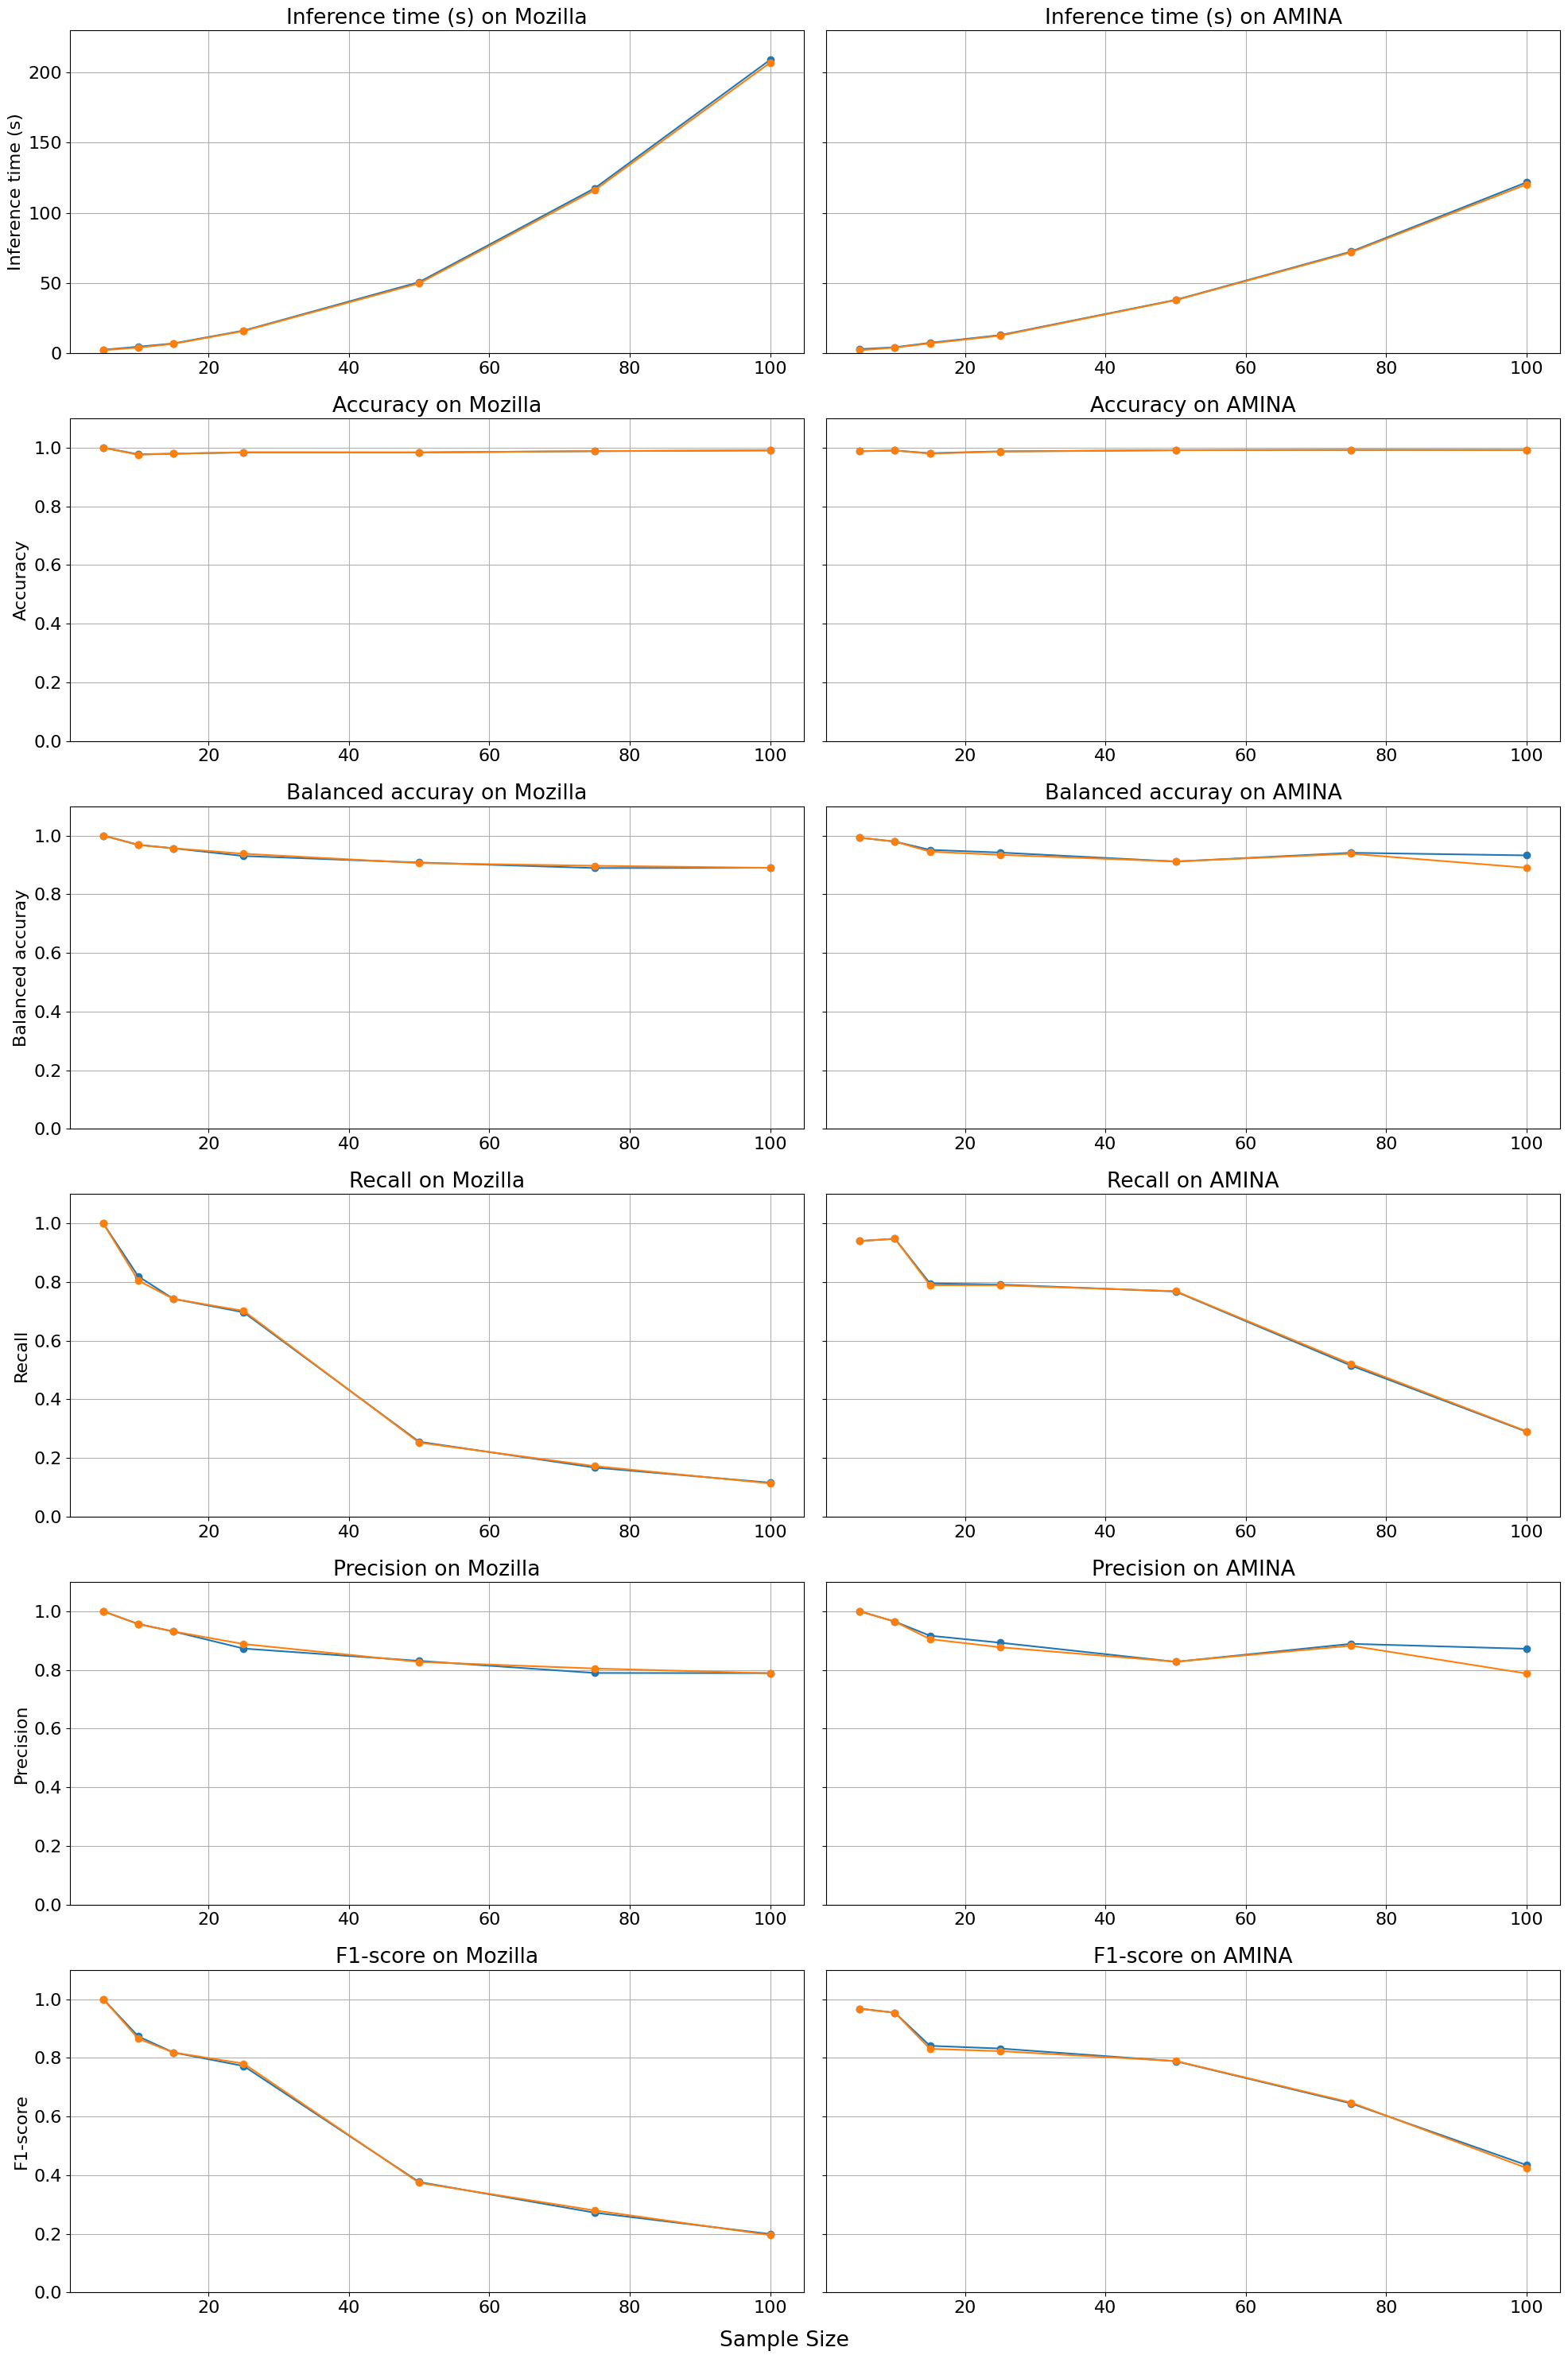

In [54]:
import numpy as np
import matplotlib.pyplot as plt

summary_dfs = {}    # dict to store statistical summary data (<session_name>.json)
all_data_dfs = {}   # dict to store all individual measurements (all_data_<session_name>.json)

experiment_data_dir = '../res' # directory generated by "eval.py", contains the .json files with the experiment data

iteration_structure = True # flag to set the directory structure of the input data

# Load all the experiment data
summary_dfs, all_data_dfs, _ = utils.load_experiment_data(experiment_data_dir, iteration_structure)

plt.rcParams.update({
    'font.size': 16  # Adjust the number to your desired base size
})

# TODO: avoid hard-coding this
sample_sizes = [5, 10, 15, 25, 50, 75, 100]

options = ['MIS_GPTQ_Mozilla', 'MIS_NONE_Mozilla', 'MIS_GPTQ_AMINA', 'MIS_NONE_AMINA']

keys = [
    ("time_to_analyze", "Inference time (s)"),
    ("accuracy", None),
    ("balanced_accuracy", "Balanced accuray"),
    ("recall", None),
    ("precision", None),
    ("f1", "F1-score")
]

# keys = list(all_data_dfs[list(all_data_dfs.keys())[0]].keys())[1:]

models = ["MIS_GPTQ", "MIS_NONE"]
datasets = ["AMINA", "Mozilla"]

# Create 1 row, 2 columns of subplots, sharing y-axis
fig, axes = plt.subplots(nrows=len(keys), ncols=2, figsize=(20, 30), sharey='row')

for i, (k, label) in enumerate(keys):
    data: list[str, list[int] | list[float]] = {
        'Sample Size': sample_sizes,
        **{k:[] for k in options}
    }
    for model in models:
        for dataset in datasets:
            for sample in sample_sizes:
                key: str = f"{model}_{dataset}-{sample}"
                t = np.mean(all_data_dfs[key][k])
                data[f"{model}_{dataset}"].append(t)
    
    df = pd.DataFrame(data)
    
    # Calculate global max y-value for consistent y-axis limits
    y_max = df[df.columns[1:5]].max().max()
    
    for method in df.columns[1:3]:
        axes[i][0].plot(df['Sample Size'], df[method], marker='o', label=method.replace("_Mozilla", ""))
        
    axes[i,0].set_title(f'{k.capitalize() if label is None else label} on Mozilla')
    axes[i,0].set_ylabel(k.capitalize() if label is None else label)
    axes[i,0].grid(True)
    axes[i,0].set_ylim(0, y_max * 1.1)    

    for method in df.columns[3:5]:
        axes[i][1].plot(df['Sample Size'], df[method], marker='o', label=method.replace("_AMINA", ""))
    axes[i][1].set_title(f'{k.capitalize() if label is None else label} on AMINA')
    axes[i][1].grid(True)
    axes[i][1].set_ylim(0, y_max * 1.1)
    fig.supxlabel('Sample Size')
    
    data = {} # reset

fig.tight_layout()
fig.savefig(f"out/RQ3.svg", format='svg')

[('MIS_GPTQ_Mozilla', array([  2.35459037,   4.54373002,   6.87129719,  16.04877567,
        50.59624792, 117.50504851, 209.08056587]), array([  5,  10,  15,  25,  50,  75, 100])), ('MIS_NONE_Mozilla', array([  2.05249641,   3.92010334,   6.57590527,  15.73304248,
        49.73849279, 116.12247646, 207.07000304]), array([  5,  10,  15,  25,  50,  75, 100])), ('MIS_GPTQ_AMINA', array([  2.81718497,   4.14100527,   7.31727909,  12.7882747 ,
        37.91702796,  72.37630667, 121.79372602]), array([  5,  10,  15,  25,  50,  75, 100])), ('MIS_NONE_AMINA', array([  2.04358246,   3.88314381,   6.9079963 ,  12.40378118,
        37.70566218,  71.85230972, 120.30545321]), array([  5,  10,  15,  25,  50,  75, 100]))]
Linearithmic Fit R^2: 0.9656
Exponential Fit R^2: 0.9467
Linearithmic Fit R^2: 0.9655
Exponential Fit R^2: 0.9406
Linearithmic Fit R^2: 0.9825
Exponential Fit R^2: 0.9473
Linearithmic Fit R^2: 0.9840
Exponential Fit R^2: 0.9302


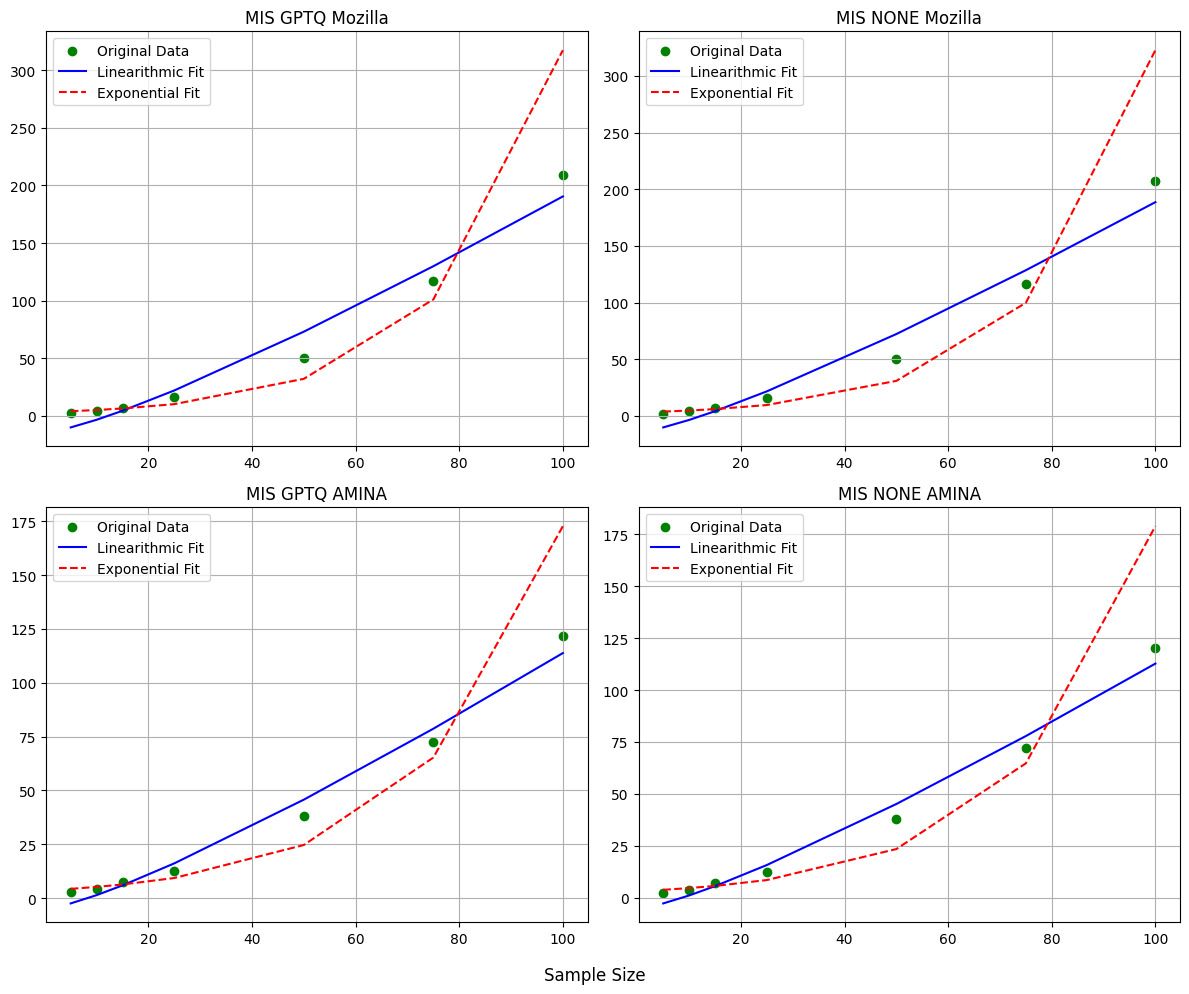

In [34]:
from scipy.stats import linregress

# List of 4 datasets (x, y) pairs
datasets = [
    (opt, np.array(data[opt]), np.array(sample_sizes)) for opt in options
]

print(datasets)

# Create a 2x2 plot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()  # Flatten to simplify indexing

# Collect all y and fitted y values from the datasets to find global min and max
all_y_values = []
for (_, y, x) in datasets:
    ln_y = np.log(y)
    slope, intercept, _, _, _ = linregress(x, ln_y)
    y_pred = np.exp(intercept + slope * x)
    all_y_values.extend(y)
    all_y_values.extend(y_pred)

# Determine global y-limits
ymin = min(all_y_values)
ymax = max(all_y_values)

# Loop through each dataset
for i, (dataset, y, x) in enumerate(datasets):
    # Take ln(y)
    ln_y = np.log(y)

    # # Linear regression
    # slope, intercept, r_value, p_value, std_err = linregress(x, ln_y)
    # ln_y_pred = intercept + slope * x
    # y_pred = np.exp(ln_y_pred)

    # Linearithmic
    z = x * np.log(x)
    slope_linlog, intercept_linlog, r_value_linlog, _, _ = linregress(z, y)
    y_pred_linlog = slope_linlog * z + intercept_linlog

    
    # Optional: Compare to exponential fit
    ln_y = np.log(y)
    slope_exp, intercept_exp, r_value_exp, _, _ = linregress(x, ln_y)
    y_pred_exp = np.exp(intercept_exp + slope_exp * x)

    # Print R^2 scores
    print(f"Linearithmic Fit R^2: {r_value_linlog**2:.4f}")
    print(f"Exponential Fit R^2: {r_value_exp**2:.4f}")


    # Plotting
    ax = axs[i]
    ax.scatter(x, y, label='Original Data', color='green')
    ax.plot(x, y_pred_linlog, label='Linearithmic Fit', color='blue')
    ax.plot(x, y_pred_exp, label='Exponential Fit', color='red', linestyle='--')
    ax.set_title(dataset.replace("_", " "))
    # ax.set_ylim(ymin, ymax)
    ax.legend()
    ax.grid(True)

fig.supxlabel('Sample Size')
plt.tight_layout()
plt.savefig("RQ3_linear_regression.svg", format='svg')
plt.show()

Print the loaded dataframes:


In [23]:
print(summary_dfs["MIS_NONE_AMINA-100"].head())

   metric  size     total      min       q1   median       q3      max  \
0   all_n    10  130000.0  13000.0  13000.0  13000.0  13000.0  13000.0   
1  all_tp    10     390.0     38.0     38.0     39.0     40.0     40.0   
2  all_tn    10  128550.0  12851.0  12852.0  12852.0  12862.0  12862.0   
3  all_fp    10     110.0      4.0      4.0     14.0     14.0     15.0   
4  all_fn    10     950.0     94.0     94.0     95.0     96.0     96.0   

      mean        sd  
0  13000.0  0.000000  
1     39.0  0.774597  
2  12855.0  4.604346  
3     11.0  4.604346  
4     95.0  0.774597  


---


## Plots, Tables, Graphs


#### **TODO** - the functions in this section are the first drafts. We need to decide on what we want and implement it.

- improve existing function or add new ones


#### Create MVP table

**Table Structure Example**:

| treatment    | accuracy    | recall | ... |
| ------------ | ----------- | ------ | --- |
| Ollama-None  | (mean ± sd) | ...    |     |
| Ollama-Q1    | ...         |        |     |
| Ollama-Q2    |             |        |     |
| Mixtral-None |             |        |     |
| Mixtral-Q1   |             |        |     |
| ...          |             |        |     |

**Note**: _treatments_ are derived from the session names (keys)


In [15]:
def format_mean_sd(mean, sd):
    """
    Formats mean and standard deviation as a string, 
    rounds to two decimal places and removes trailing zeros.

    Example: "3.1 ± 0.2"
    """
    # Note: values are converted to floats to we don't risk creating empty strings
    mean_str = f"{mean:.2f}".rstrip("0").rstrip(".")
    sd_str = f"{sd:.2f}".rstrip("0").rstrip(".")

    return f"{mean_str} ± {sd_str}"


def create_mvp_table_df(summary_dataframes: dict[str: pd.DataFrame]):
    """
    Creates a table with treatments as rows and metrics as columns,
    showing values as (mean +- standard deviation).
    """

    # Make a temporary copy so we don't modify the original data
    temp_dfs = summary_dataframes.copy()

    # Construct new dataframe with the treatment column populated with the session keys
    treatment_df = pd.DataFrame({"treatment": [key for key in temp_dfs]})
    
    # Dynamically constructs an empty dataframe with the metrics values as column names
    # Each row will hold the data of a session (treatment)
    metrics_df = pd.DataFrame(
            columns=[metrics for metrics in temp_dfs[next(iter(temp_dfs))]["metric"]]
        )
    
    # Iterate over each session key, construct new row with (mean ± sd) values for each metric
    # Note: concatenating dfs in a loop is technically inefficient (could construct using lists)
    #       but we will not have enough treatments for it to really matter.
    for session_key in temp_dfs:
        # Combine columns to create String representations of: mean ± standard deviation
        mean_and_sd = temp_dfs[session_key].apply(
                lambda row: format_mean_sd(row["mean"], row["sd"]), axis=1
            )

        # Convert series to dataframe so we can transpose from column to row
        mean_and_sd_df = mean_and_sd.to_frame().T

        # Copy the column names for easy concatenation
        mean_and_sd_df.columns = metrics_df.columns

        # Add the row to the metrics dataframe
        metrics_df = pd.concat([metrics_df, mean_and_sd_df], ignore_index=True)

    # Concatenate the treatment and metrics dataframes to create the final table
    combined_table_df = pd.concat([treatment_df, metrics_df], axis=1) # concatenates horizontally

    return combined_table_df
            

In [27]:
table_df = create_mvp_table_df(summary_dfs)

print(table_df)

               treatment            all_n        all_tp           all_tn  \
0     MIS_NONE_AMINA-100        13000 ± 0     39 ± 0.77      12855 ± 4.6   
1      MIS_GPTQ_AMINA-15       336 ± 68.8   17.2 ± 1.78    311.7 ± 63.96   
2      MIS_NONE_AMINA-15       336 ± 68.8   17.1 ± 1.87    311.5 ± 64.52   
3       MIS_GPTQ_AMINA-5      33.5 ± 5.02     6.3 ± 1.1      26.8 ± 4.02   
4      MIS_GPTQ_AMINA-25    847.5 ± 96.47   26.5 ± 3.69    809.7 ± 91.39   
5      MIS_NONE_AMINA-25    847.5 ± 96.47   26.4 ± 3.95     809.2 ± 91.7   
6     MIS_GPTQ_AMINA-100        13000 ± 0    38.8 ± 0.6   12859.9 ± 4.46   
7       MIS_NONE_AMINA-5      33.5 ± 5.02     6.3 ± 1.1      26.8 ± 4.02   
8    MIS_GPTQ_Mozilla-25      505 ± 44.44   14.1 ± 2.17    482.7 ± 42.63   
9    MIS_NONE_Mozilla-25      505 ± 44.44   14.2 ± 2.18    482.9 ± 42.44   
10   MIS_GPTQ_Mozilla-15      183 ± 26.66    8.9 ± 1.87    170.2 ± 24.97   
11   MIS_NONE_Mozilla-15      183 ± 26.66    8.9 ± 1.87    170.2 ± 24.97   
12   MIS_GPT

**Plot MVP table [WIP]**


In [21]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
from itertools import cycle

def treatment_sort_key(treatment):
    # Define custom quantization order
    quant_order = {"NONE": 0, "AWQ": 1, "GPTQ": 2, "AQLM": 3}
    
    parts = treatment.split("_")
    
    if len(parts) == 3:
        model, quant, dataset = parts
    else:
        return (999, 999)  # Push malformed rows to the end
    return (dataset, quant_order.get(quant, 999))

def prettify_col(col):
    """
    Clean up and prettify the column names.
    """
    col = col.replace("all_", "").replace("_", " ")
    words = col.split()
    return " ".join( # inserts a space character between concatenated strings
        (
            w.upper() if w.lower() in {"tp", "tn", "fp", "fn", "f1", "gpu", "vram"} # all caps for acronyms
            else "MiB" if w.lower() == "mib" # MiB needs special capitalization
            else w if w.lower() in {"n", "to"} # lowercase for sample size and "to" in "Time-to-Analyze"
            else w.title() # title capitalization if multi-word
        )
        for w in words
    )


def plot_table(df, title, max_fontsize=12, min_fontsize=6):
    nrows, ncols = df.shape

    # Dynamically determine figure size
    cell_width = 1.2
    cell_height = 0.5
    fig_width = max(16, ncols * cell_width)
    fig_height = max(3, nrows * cell_height + 1.5)  # More room for long tables and title

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.set_title(title, fontsize=14, fontweight="bold", pad=25)
    ax.axis("off")

    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     loc="upper center",
                     cellLoc="center",
                     colLoc="center")

    # Font size based on number of columns
    base_font = max(min_fontsize, min(max_fontsize, int(100 / max(ncols, 1))))
    table.auto_set_font_size(False)
    table.set_fontsize(base_font)

    # More breathing room between rows/columns
    table.scale(1.1, 1.4)

    # Ensure layout includes title + large tables
    plt.subplots_adjust(top=0.85, bottom=0.05)
    plt.show()


#========================= Plotting functions generated using ChatGPT 4o =========================#

def plot_table_highlight_max_per_group(df, title, max_fontsize=12, min_fontsize=6):

    # Define highlight colors for ties
    highlight_colors = [
        "#fff2ac",  # pale yellow
        "#c2f0c2",  # light green
        "#add8e6",  # light blue
        "#f7c6c7",  # light pink
        "#e0bbff",  # light purple
        "#ffd9b3",  # light orange
    ]
    color_cycle = cycle(highlight_colors)

    # Add helper column for dataset extraction
    df = df.copy()
    df["__Dataset__"] = df["Treatment"].apply(lambda x: x.split("_")[-1] if isinstance(x, str) else "UNKNOWN")

    # Build new DataFrame with spacer rows
    df_blocks = []
    color_blocks = []

    first_group = True

    for dataset, group_df in df.groupby("__Dataset__"):
        group_df = group_df.copy()
        group_df_indices = group_df.index.tolist()
        group_colors = [["white"] * (df.shape[1] - 1) for _ in range(len(group_df))]  # no __Dataset__ in table

        # Highlight max values per metric column in this group
        for j in range(1, df.shape[1] - 1):  # skip Treatment and __Dataset__
            try:
                col_values = group_df.iloc[:, j].astype(str)
                parsed_values = col_values.str.extract(r"([0-9.]+)").astype(float)[0]
                max_val = parsed_values.max()
                tied_rows = parsed_values[parsed_values == max_val].index.tolist()

                color = next(color_cycle)

                for idx in tied_rows:
                    rel_row = group_df.index.get_loc(idx)
                    group_colors[rel_row][j] = color
            except Exception as e:
                print(f"Skipping column {df.columns[j]} for dataset {dataset} due to error: {e}")

        # Drop helper column before display
        group_df = group_df.drop(columns="__Dataset__")

        # Add an empty row (spacer)
        if not first_group:
            empty_row = pd.DataFrame([[ "" for _ in group_df.columns]], columns=group_df.columns)
            df_blocks.append(empty_row)
            color_blocks.append(["white"] * len(group_df.columns))
        first_group = False

        # Append the group
        df_blocks.append(group_df)

        # Append matching color block
        color_blocks.extend(group_colors)



    # Final merged DataFrame and color matrix
    final_df = pd.concat(df_blocks, ignore_index=True)
    nrows, ncols = final_df.shape
    cell_colors = color_blocks

    # Plot
    fig_width = max(16, ncols * 1.2)
    fig_height = max(3, nrows * 0.5 + 1.5)
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.set_title(title, fontsize=14, fontweight="bold", pad=25)
    ax.axis("off")

    table = ax.table(cellText=final_df.values,
                     colLabels=final_df.columns,
                     cellLoc="center",
                     colLoc="center",
                     cellColours=cell_colors,
                     loc="upper center")

    base_font = max(min_fontsize, min(max_fontsize, int(100 / max(ncols, 1))))
    table.auto_set_font_size(False)
    table.set_fontsize(base_font)
    table.scale(1.1, 1.4)
    plt.subplots_adjust(top=0.85, bottom=0.05)
    plt.show()


def plot_table_highlight_min_per_group(df, title, max_fontsize=12, min_fontsize=6):

    # Colors to cycle through for ties
    highlight_colors = [
        "#fff2ac",  # pale yellow
        "#c2f0c2",  # light green
        "#add8e6",  # light blue
        "#f7c6c7",  # light pink
        "#e0bbff",  # light purple
        "#ffd9b3",  # light orange
    ]
    color_cycle = cycle(highlight_colors)

    # Add helper column to identify dataset group
    df = df.copy()
    df["__Dataset__"] = df["Treatment"].apply(lambda x: x.split("_")[-1] if isinstance(x, str) else "UNKNOWN")

    df_blocks = []
    color_blocks = []

    first_group = True

    for dataset, group_df in df.groupby("__Dataset__"):
        group_df = group_df.copy()
        group_df_indices = group_df.index.tolist()
        group_colors = [["white"] * (df.shape[1] - 1) for _ in range(len(group_df))]  # no __Dataset__ column

        for j in range(1, df.shape[1] - 1):  # skip "Treatment" and "__Dataset__"
            try:
                col_values = group_df.iloc[:, j].astype(str)
                parsed_values = col_values.str.extract(r"([0-9.]+)").astype(float)[0]
                min_val = parsed_values.min()
                tied_rows = parsed_values[parsed_values == min_val].index.tolist()

                color = next(color_cycle)
                for idx in tied_rows:
                    rel_row = group_df.index.get_loc(idx)
                    group_colors[rel_row][j] = color
            except Exception as e:
                print(f"Skipping column {df.columns[j]} for dataset {dataset} due to error: {e}")

        group_df = group_df.drop(columns="__Dataset__")
        
        # Add empty spacer row
        if not first_group:
            empty_row = pd.DataFrame([[ "" for _ in group_df.columns]], columns=group_df.columns)
            df_blocks.append(empty_row)
            color_blocks.append(["white"] * len(group_df.columns))
        first_group = False

        df_blocks.append(group_df)
        color_blocks.extend(group_colors)



    final_df = pd.concat(df_blocks, ignore_index=True)
    nrows, ncols = final_df.shape
    cell_colors = color_blocks

    # Plotting
    fig_width = max(16, ncols * 1.2)
    fig_height = max(3, nrows * 0.5 + 1.5)
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.set_title(title, fontsize=14, fontweight="bold", pad=25)
    ax.axis("off")

    table = ax.table(cellText=final_df.values,
                     colLabels=final_df.columns,
                     cellLoc="center",
                     colLoc="center",
                     cellColours=cell_colors,
                     loc="upper center")

    base_font = max(min_fontsize, min(max_fontsize, int(100 / max(ncols, 1))))
    table.auto_set_font_size(False)
    table.set_fontsize(base_font)
    table.scale(1.1, 1.4)
    plt.subplots_adjust(top=0.85, bottom=0.05)
    plt.show()


def plot_table_highlight_metric_direction(df, title, maximize_cols=None, minimize_cols=None, max_fontsize=12, min_fontsize=6):
    
    maximize_cols = {
        "Balanced Accuracy", "Precision", "Recall", "F1"
    }
    minimize_cols = {
        "Time to Analyze", "VRAM Max Usage MiB"
    }

    if maximize_cols is None: maximize_cols = set()
    if minimize_cols is None: minimize_cols = set()

    # Define highlight colors
    highlight_colors = [
        "#fff2ac", "#c2f0c2", "#add8e6", "#f7c6c7", "#e0bbff", "#ffd9b3"
    ]
    color_cycle = cycle(highlight_colors)

    df = df.copy()
    df["__Dataset__"] = df["Treatment"].apply(lambda x: x.split("_")[-1] if isinstance(x, str) else "UNKNOWN")

    df_blocks = []
    color_blocks = []

    spacer_row_indices = []
    label_row_indices = []

    first_group = True


    for dataset, group_df in df.groupby("__Dataset__"):
        group_df = group_df.copy()
        group_colors = [["white"] * (df.shape[1] - 1) for _ in range(len(group_df))]


        for j in range(1, df.shape[1] - 1):  # skip Treatment and __Dataset__
            col_name = df.columns[j]
            direction = "max" if col_name in maximize_cols else "min" if col_name in minimize_cols else None

            if direction:
                try:
                    col_values = group_df.iloc[:, j].astype(str)
                    parsed_values = col_values.str.extract(r"([0-9.]+)").astype(float)[0]   
                    target_val = parsed_values.max() if direction == "max" else parsed_values.min()
                    tied_rows = parsed_values[parsed_values == target_val].index.tolist()

                    color = next(color_cycle)

                    best_std = float("inf")
                    final_idxs = []
                    
                    for idx in tied_rows:
                        rel_row = group_df.index.get_loc(idx)  # Get relative position in group_df
                        val_str = group_df.iloc[rel_row, j]
                        match = re.search(r"±\s*([0-9.]+)", str(val_str))
                        std = float(match.group(1)) if match else float("inf")

                        if std < best_std:
                            best_std = std
                            final_idxs = [rel_row]
                        elif std == best_std:
                            final_idxs.append(rel_row)

                    # Highlight only the most precise among the tied means
                    for rel_row in final_idxs:
                        group_colors[rel_row][j] = color

                except Exception as e:
                    print(f"Skipping column {col_name} for dataset {dataset} due to error: {e}")

        group_df = group_df.drop(columns="__Dataset__")

        # Add empty spacer row
        if not first_group:
            empty_row = pd.DataFrame([[ "" for _ in group_df.columns]], columns=group_df.columns)
            df_blocks.append(empty_row)
            color_blocks.append(["white"] * len(group_df.columns))
            spacer_row_indices.append(sum(len(block) for block in df_blocks) - 1) # index of spacer row in final_df

        first_group = False

        # Format Treatment column to show only "<model>_<quantization>"
        group_df["Treatment"] = group_df["Treatment"].apply(lambda x: "_".join(x.split("_")[:2]) if isinstance(x, str) else x)

        # Add banner row before each group
        banner_text = f"Dataset: {dataset}"
        banner_row = pd.DataFrame([[banner_text] + [""] * (len(group_df.columns) - 1)], columns=group_df.columns)
        banner_colors = ["#d3d3d3"] + ["white"] * (len(group_df.columns) - 1)  # gray background for label

        df_blocks.append(banner_row)
        color_blocks.append(banner_colors)
        label_row_indices.append(sum(len(block) for block in df_blocks) - 1)  # Track row index of label

        df_blocks.append(group_df)
        color_blocks.extend(group_colors)

    final_df = pd.concat(df_blocks, ignore_index=True)
    nrows, ncols = final_df.shape
    cell_colors = color_blocks

    # Plotting
    fig_width = max(17, ncols * 1.2)
    fig_height = max(3, nrows * 0.5 + 1.5)
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.set_title(title, fontsize=14, fontweight="bold", pad=25)
    ax.axis("off")

    table = ax.table(cellText=final_df.values,
                     colLabels=final_df.columns,
                     cellLoc="center",
                     colLoc="center",
                     cellColours=cell_colors,
                     loc="upper center")
    
    # Add color to column headers
    header_color = "#d0e0f0"  # light blue
    for col_idx, col_name in enumerate(final_df.columns):
        cell = table[0, col_idx]
        cell.set_facecolor(header_color)
        cell.set_text_props(weight='bold')
    
    # Remove horizontal + vertical borders for spacer rows (except for leftmost cell)
    for row_idx in spacer_row_indices:
        for col_idx in range(ncols):
            cell = table[row_idx + 1, col_idx]  # +1 because header row is row 0
            if col_idx == 0:
                cell.visible_edges = ''  # fully remove all borders from first cell
            else:
                cell.visible_edges = ''  # no horizontal or vertical borders for spacer cells
    
    # Style dataset label rows: bold left cell and clean borders
    for row_idx in label_row_indices:
        for col_idx in range(1, ncols):  # only columns 1 and onward
            cell = table[row_idx + 1, col_idx]  # +1 for header offset
            if col_idx == 0:
                cell.visible_edges = 'horizontal'
                cell.get_text().set_weight('bold')  # Make text bold
            else:
                cell.visible_edges = ""

    base_font = max(min_fontsize, min(max_fontsize, int(100 / max(ncols, 1))))
    table.auto_set_font_size(False)
    table.set_fontsize(base_font)
    table.scale(1.1, 1.4)
    plt.subplots_adjust(top=0.85, bottom=0.05)
    plt.show()



# "TP", "TN", "FP", "FN",
efficacy_cols = ["Treatment", "Accuracy", "Balanced Accuracy", "F1", "Recall", "Precision", "Specificity"]
efficiency_cols = ["Treatment", "Time to Analyze", "GPU Util Mean", "GPU Util Max", "VRAM Util Mean", "VRAM Util Max", "VRAM Max Usage MiB"]
key_metrics_cols = ["Treatment", "Balanced Accuracy", "Precision", "Recall", "F1", "Time to Analyze", "VRAM Max Usage MiB"]

# Copy the table so we don't modify the original
copy_df = table_df.copy()

# Prettify column names
copy_df.columns = [prettify_col(col) for col in copy_df.columns]

# Sort the DataFrame by dataset + custom quantization order
copy_df = copy_df.sort_values(by="Treatment", key=lambda col: col.map(treatment_sort_key)).reset_index(drop=True)


df_main = copy_df[efficacy_cols]
df_resource = copy_df[efficiency_cols]
df_most_interesting = copy_df[key_metrics_cols]

plot_table_highlight_max_per_group(df_main, "RQ1: Efficacy Summary")
plot_table_highlight_min_per_group(df_resource, "RQ2: Efficiency Summary")
plot_table_highlight_metric_direction(df_most_interesting, "Key Metrics Summary")

# Transposed version: treatments as column names
transposed_df = df_most_interesting.set_index("Treatment").T.reset_index()
transposed_df.columns = ["Metric"] + list(transposed_df.columns[1:])

plot_table(transposed_df, "Key Metrics Summary (Transposed)")

KeyError: "['GPU Util Mean', 'GPU Util Max', 'VRAM Util Mean', 'VRAM Util Max', 'VRAM Max Usage MiB'] not in index"

**Output dataframe to Latek format [WIP]**


In [22]:
# Make copy to keep original dataframe intact
latex_df = table_df.copy()

# Fix column names
latex_df.columns = [prettify_col(col) for col in latex_df.columns]

# Replace the special character "±" with its latex equivalent and wrap values in math mode
for col in latex_df.columns:
    if col != "Treatment":
        latex_df[col] = latex_df[col].apply(
            lambda x: "$" + str(x).replace("±", "\\pm") + "$"
        )

# TODO: column names out-of-date
latex_mvp_table = latex_df.to_latex(
    index=False, 
    columns=[
        "Treatment", 
        "Accuracy", 
        "Balanced Accuracy", 
        "F1", 
        "Recall", 
        "Precision", 
        "Time To Analyze", 
        "Memory Usage"
        ]
    )

#print(latex_df.columns)
print(latex_mvp_table)

\begin{tabular}{llllll}
\toprule
Treatment & Accuracy & Balanced Accuracy & F1 & Recall & Precision \\
\midrule
MIS_NONE_AMINA-100 & $0.99 \pm 0$ & $0.89 \pm 0.04$ & $0.42 \pm 0.01$ & $0.29 \pm 0.01$ & $0.79 \pm 0.08$ \\
MIS_GPTQ_AMINA-15 & $0.98 \pm 0.01$ & $0.95 \pm 0.04$ & $0.84 \pm 0.11$ & $0.8 \pm 0.17$ & $0.92 \pm 0.08$ \\
MIS_NONE_AMINA-15 & $0.98 \pm 0.01$ & $0.95 \pm 0.04$ & $0.83 \pm 0.1$ & $0.79 \pm 0.16$ & $0.9 \pm 0.08$ \\
MIS_GPTQ_AMINA-5 & $0.99 \pm 0.01$ & $0.99 \pm 0.01$ & $0.97 \pm 0.04$ & $0.94 \pm 0.07$ & $1 \pm 0$ \\
MIS_GPTQ_AMINA-25 & $0.99 \pm 0.01$ & $0.94 \pm 0.07$ & $0.83 \pm 0.14$ & $0.79 \pm 0.16$ & $0.89 \pm 0.14$ \\
MIS_NONE_AMINA-25 & $0.99 \pm 0.01$ & $0.93 \pm 0.07$ & $0.82 \pm 0.15$ & $0.79 \pm 0.17$ & $0.88 \pm 0.14$ \\
MIS_GPTQ_AMINA-100 & $0.99 \pm 0$ & $0.93 \pm 0.04$ & $0.43 \pm 0.01$ & $0.29 \pm 0$ & $0.87 \pm 0.07$ \\
MIS_NONE_AMINA-5 & $0.99 \pm 0.01$ & $0.99 \pm 0.01$ & $0.97 \pm 0.04$ & $0.94 \pm 0.07$ & $1 \pm 0$ \\
MIS_GPTQ_Mozilla-25 & $0